In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
from tensorflow. keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn. model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

In [3]:
print(tf. __version__)

2.18.0


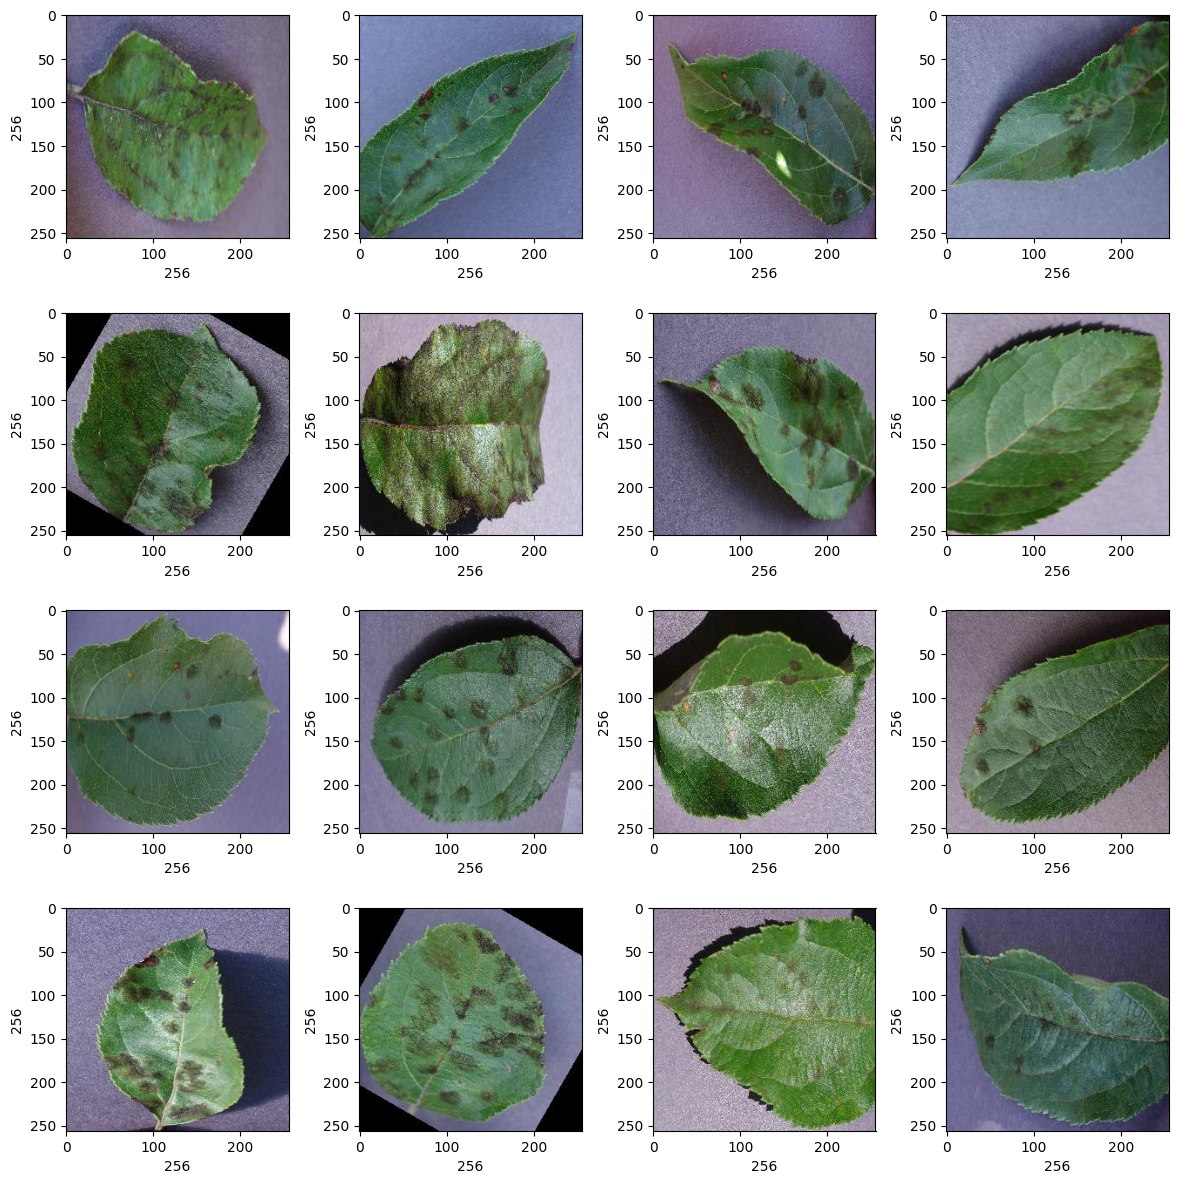

In [4]:
# Plotting 12 images to check dataset

plt.figure(figsize = (12, 12))
dataset_path = "/content/drive/MyDrive/Apple_dataset/train/apple_scab"

for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(dataset_path +'/'+ random.choice(sorted(os.listdir(dataset_path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10) # width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10) # height of image

In [5]:
# Converting Images to array

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256, 256))
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
dataset_path = "/content/drive/MyDrive/Apple_dataset/train"
labels = ['apple_scrab', 'black_rot', 'cedar_apple_rust', 'healthy']
print(labels)

['apple_scrab', 'black_rot', 'cedar_apple_rust', 'healthy']


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Step 1: Set your dataset path
dataset_path = "/content/drive/MyDrive/Apple_dataset/train"

# Step 2: Set parameters
img_size = (256, 256)
batch_size = 32

# Step 3: Load training and validation datasets
raw_train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# ✅ Save class names BEFORE mapping
class_names = raw_train_ds.class_names
print("✅ Class names:", class_names)

# Step 4: Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# ✅ Apply normalization and prefetching together
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    raw_train_ds
    .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    raw_val_ds
    .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

print("✅ Dataset is now ready for training (loaded in batches, memory-safe).")


Found 7816 files belonging to 4 classes.
Using 6253 files for training.
Found 7816 files belonging to 4 classes.
Using 1563 files for validation.
✅ Class names: ['apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']
✅ Dataset is now ready for training (loaded in batches, memory-safe).


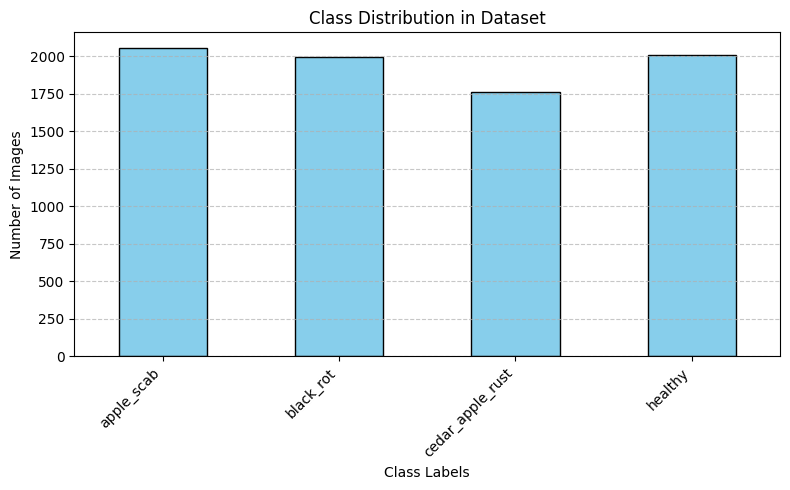

In [8]:
import os, pandas as pd, matplotlib.pyplot as plt

dataset_path = "/content/drive/MyDrive/Apple_dataset/train"

# Build {class_name: file_count} dictionary
class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(dataset_path, cls))
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    for cls in sorted(os.listdir(dataset_path))
}

label_counts = pd.Series(class_counts)

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
import tensorflow as tf
print("🔧 GPU Available:", tf.config.list_physical_devices('GPU'))


🔧 GPU Available: []


In [10]:
'''# Take one batch from the dataset
for images, labels in train_ds.take(1):
    first_label = labels[0].numpy()
    print("✅ Batch shape:", images.shape)           # e.g. (32, 256, 256, 3)
    print("✅ Shape of first image:", images[0].shape)
    print("✅ Label of first image (numeric):", first_label)
    print("✅ Class name:", class_names[first_label])
    break'''




'# Take one batch from the dataset\nfor images, labels in train_ds.take(1):\n    first_label = labels[0].numpy()\n    print("✅ Batch shape:", images.shape)           # e.g. (32, 256, 256, 3)\n    print("✅ Shape of first image:", images[0].shape)\n    print("✅ Label of first image (numeric):", first_label)\n    print("✅ Class name:", class_names[first_label])\n    break'

In [11]:
total_images = 0

for images, labels in train_ds.unbatch():
    total_images += 1

print("✅ Total number of images in training set:", total_images)


✅ Total number of images in training set: 6253


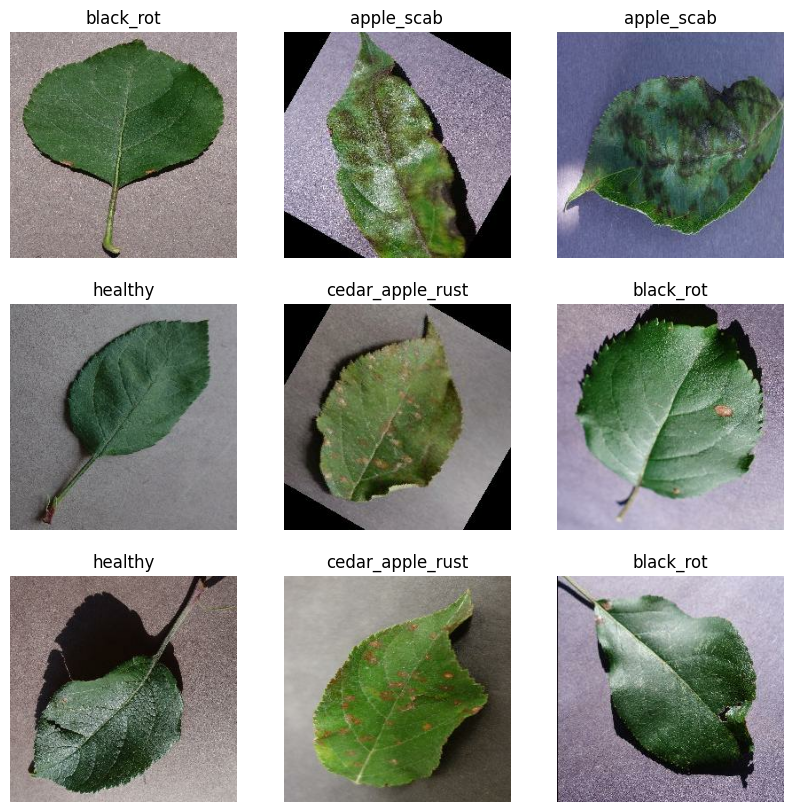

In [12]:
import matplotlib.pyplot as plt

# ✅ Use class_names saved from raw_train_ds
# class_names = raw_train_ds.class_names  # Already stored earlier

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),


    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Create the checkpoints directory in your Drive
checkpoint_dir = '/content/drive/MyDrive/Apple_dataset/CheckPoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Set path to save model after every epoch
checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.keras')

# Define checkpoint callback — saves model after every epoch
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # saves the full model
    verbose=1,
    save_best_only=False      # save after every epoch, not just the best one
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint_cb]  # <-- This avoids unnecessary long training
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6201 - loss: 1.0978
Epoch 1: saving model to /content/drive/MyDrive/Apple_dataset/CheckPoints/model_epoch_01.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 900s 5s/step - accuracy: 0.6208 - loss: 1.0956 - val_accuracy: 0.8356 - val_loss: 0.4481
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8773 - loss: 0.3446
Epoch 2: saving model to /content/drive/MyDrive/Apple_dataset/CheckPoints/model_epoch_02.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - accuracy: 0.8774 - loss: 0.3445 - val_accuracy: 0.9066 - val_loss: 0.2693
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9269 - loss: 0.2194
Epoch 3: saving model to /content/drive/MyDrive/Apple_dataset/CheckPoints/model_epoch_03.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.9269 - loss: 0.2193 - val_accuracy: 0.9399 - val_loss: 0.1709
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9417 - loss: 0.1628
Epoch 4: saving model

In [16]:
model.save('/content/drive/MyDrive/Apple_dataset/final_apple_model.keras')

In [17]:
import os

model_path = "/content/drive/MyDrive/Apple_dataset/final_apple_model.keras"

if os.path.exists(model_path):
    print("✅ Model is successfully saved in Drive!")
else:
    print("❌ Model NOT found! Check the save path.")

✅ Model is successfully saved in Drive!


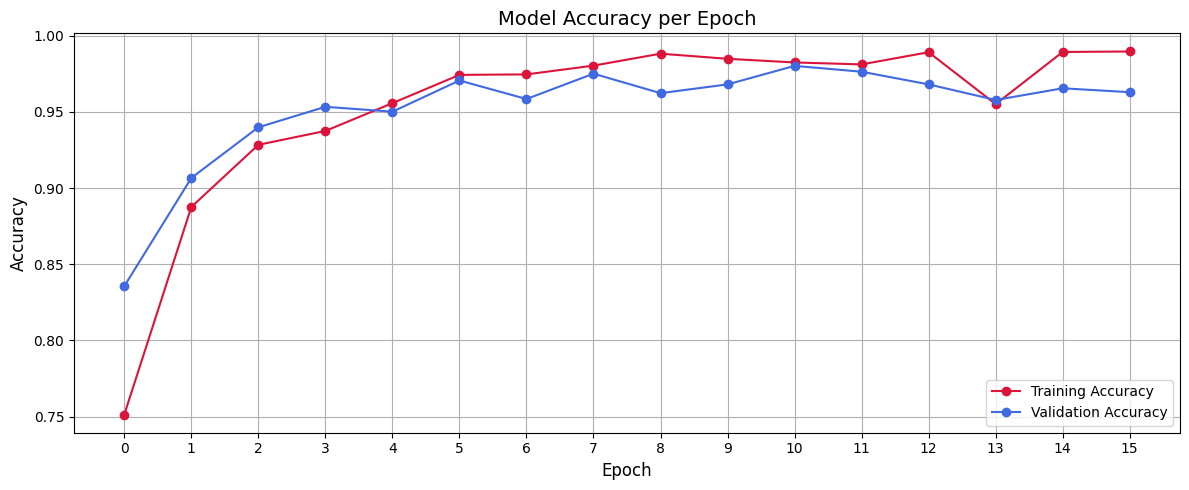

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], marker='o', color='crimson', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', color='royalblue', label='Validation Accuracy')

# Add titles and labels
plt.title('Model Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(len(history.history['accuracy'])))  # Ensure all epochs are shown
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
print("✅ Calculating model accuracy on validation set...")

# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(val_ds, verbose=1)

print(f"🧪 Validation Loss: {loss:.4f}")
print(f"🎯 Validation Accuracy: {accuracy * 100:.2f}%")

✅ Calculating model accuracy on validation set...
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 786ms/step - accuracy: 0.9809 - loss: 0.0871
🧪 Validation Loss: 0.0892
🎯 Validation Accuracy: 98.02%


In [20]:
y_pred = model.predict(val_ds)


49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 802ms/step


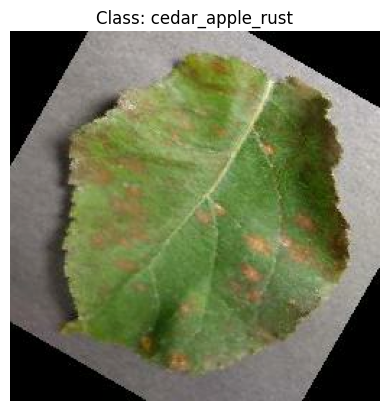

In [21]:
from tensorflow.keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt

# Take one batch from val_ds
for images, labels in val_ds.take(1):
    img = array_to_img(images[11])  # 12th image in the batch
    label_index = labels[11].numpy()
    break

# Display the image
plt.imshow(img)
plt.title(f"Class: {class_names[label_index]}")
plt.axis('off')
plt.show()

In [22]:
# Step 1: Unbatch validation set to access individual images and labels
val_unbatched = list(val_ds.unbatch().as_numpy_iterator())

# Step 2: Extract the image and label for the 12th sample
image_12, actual_label_12 = val_unbatched[11]

# Step 3: Predict using the model (make sure you’ve already predicted on val_ds)
# If not already predicted:
# val_images = np.array([sample[0] for sample in val_unbatched])
# y_pred = model.predict(val_images)

# Step 4: Display actual and predicted class names
print("✅ Originally :", class_names[actual_label_12])
print("✅ Predicted  :", class_names[np.argmax(y_pred[11])])
print("📊 Prediction probabilities for the 3rd image:", y_pred[2])

✅ Originally : cedar_apple_rust
✅ Predicted  : cedar_apple_rust
📊 Prediction probabilities for the 3rd image: [2.8417776e-07 9.9999970e-01 9.5057934e-11 1.3303824e-12]


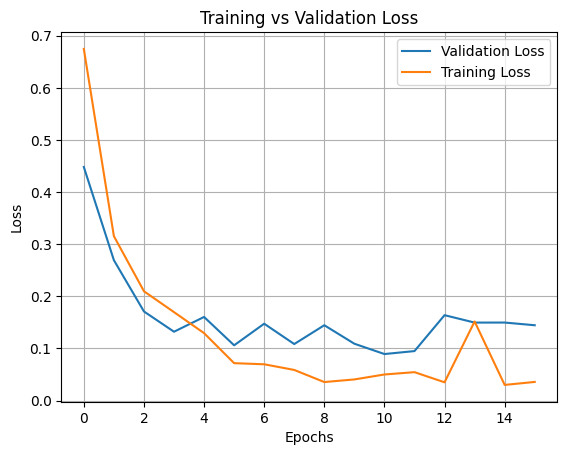

In [23]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()